In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# sns.set(font_scale=1.2)
# Function `set` is deprecated in favor of `set_theme`
# https://seaborn.pydata.org/generated/seaborn.set_theme.html

print('Automobilių kainos vertinimas.\nAntroji projekto versija.')

# Šis failas:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/Studentai/MykolasOK/2024-11-13_autop.ipynb
# Duomenų šaltiniai:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/atlyginimai.csv (-)
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/WEBscr.db (+)

Automobilių kainos vertinimas.
Antroji projekto versija.


In [107]:
import re
from datetime import datetime

def extract_year(date_str):
    if not date_str:
        return None  # Grąžiname None, jei eilutė tuščia ar None

    # Reguliarioji išraiška, ieškanti metų ISO formato datos dalyje (YYYY-MM-DD arba YYYY-MM)
    match = re.search(r'\b(\d{4})\b', date_str)

    if match:
        year = int(match.group(1))
    
        # Patikriname, ar metai atitinka protingą intervalą (pvz., nuo 1000 iki dabartinių metų)
        current_year = datetime.now().year
        if 1900 < year < current_year+2:
            return year

    return None  # Grąžiname None, jei metų rasti nepavyko

# print(extract_year("2023-05-12"))  # rezultatas: 2023
# print(extract_year("2020-05"))     # rezultatas: 2023
# print(extract_year("1999"))        # rezultatas: 1999
# print(extract_year("nėra datos"))  # rezultatas: None
# print(extract_year(""))            # rezultatas: None
# print(extract_year("9999-12-31"))  # rezultatas: None

In [137]:
import pandas as pd
import numpy as np

def extract_year_float( date_str:str, default_month:int=0 ):
    """
    Funkcija, kuri iš ISO datos ištraukia metus ir mėnesį bei grąžina metus kaip float.
    
    :param date_str: (str) ISO formato data arba dalinė data.
    :param default_month: (int) Mėnesio reikšmė, kuri naudojama, jei mėnuo nenurodytas.
    :return: (float) Metai + mėnuo / 12 arba NaN, jei metai nenurodyti.
    """
    try:
        if default_month > 12:
            default_month = 0

        # Bandome pilną datą (%Y-%m-%d)
        parsed_date = pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')
        
        if pd.isna(parsed_date):
            # Jei pilna data nepavyko, bandome tik metus ir mėnesį (%Y-%m)
            parsed_date = pd.to_datetime(date_str, format='%Y-%m', errors='coerce')
            
        if pd.isna(parsed_date):
            # Jei nepavyko nei vienas formatas, bandome tik metus (%Y)
            year_only = pd.to_datetime(date_str, format='%Y', errors='coerce')
            if pd.isna(year_only):
                return np.nan  # Jei metai nenurodyti, grąžiname NaN
            else:
                # Metai nurodyti, mėnuo nenurodytas
                return float(year_only.year + default_month/12 - (1/24 if default_month > 0 else 0))
            
        # Jei sėkmingai išanalizuota data (pilna arba tik metai ir mėnuo)
        year = parsed_date.year
        month = parsed_date.month
        return float(year + month/12 - (1/24 if month > 0 else 0))
    
    except Exception as e:
        # Jei įvyksta klaida, grąžiname NaN
        return np.nan

print(extract_year_float("2023-06-12"))  # rezultatas: 2023.4583333333333
# print(extract_year_float("1999-12-12"))  # rezultatas: 1999.9583333333333
# print(extract_year_float("2020-07"))     # rezultatas: 2020.5416666666665
# print(extract_year_float("2020-24"))     # rezultatas: nan
# print(extract_year_float("1999"))        # rezultatas: 1999.0
# print(extract_year_float("1999-12"))     # rezultatas: 1999.9583333333333
# print(extract_year_float("nėra datos"))  # rezultatas: nan
# print(extract_year_float(""))            # rezultatas: nan
# print(extract_year_float("9999-12-31"))  # rezultatas: nan

2023.4583333333333


In [49]:
print("Automobilių duomenys paimami iš DB failo")
conn = sqlite3.connect('../../DATA/WEBscr.db')
# query = "SELECT name FROM sqlite_master WHERE type='table';"
# print(pd.read_sql_query(query, conn)['name'].tolist())
query = '''SELECT TAutos.*, TUrl.url, TUrl.name, TUrl.params
            FROM TAutos
            LEFT JOIN TUrl ON TAutos.id = TUrl.id
            GROUP BY TAutos.id;'''
df=pd.read_sql_query(query, conn) # Kuriamas df.
# print(df.columns,end='\n')

print('Paimta įrašų:',len(df))

Automobilių duomenys paimami iš DB failo
Paimta įrašų: 35913


In [ ]:
import pandas as pd

print("Funkcija 'extract_values(params:str)' ištraukia kainą, galią ir tūrį iš 'params' lauko.")

def extract_values(params:str):
    kaina = None
    rida  = None
    galia = None
    turis = None
    gdata = None
    miestas = None
    
    # Konvertuojame į mažąsias raides ir skirstome pagal ';' ir ',' kaip laukų atskyriklius
    laukeliai = params.lower().replace(';', ',').split(',')
    for laukas in laukeliai:
        laukas = laukas.strip()
        
        # Paieška kainos su '€'
        if '€' in laukas:
            try:
                kaina = int(laukas.replace('€', '').replace(' ', '').strip())
            except ValueError:
                pass  # Jei negalima konvertuoti, praleidžiame
            
        # Paieška galios su 'kW'
        elif 'km' in laukas:
            try:
                rida = int(laukas.replace('km', '').replace(' ', '').strip())
            except ValueError:
                pass  # Jei negalima konvertuoti, praleidžiame
            
        # Paieška galios su 'kW'
        elif 'kw' in laukas:
            try:
                galia = int(laukas.replace('kw', '').replace(' ', '').strip())
            except ValueError:
                pass
            
        # Paieška tūrio su 'l.'
        elif 'l.' in laukas:
            try:
                turis = float(laukas.replace('l.', '').replace(' ', '').strip())
            except ValueError:
                pass

        # Metų paieška
        else:
            year_find = extract_year(laukas)
            if year_find:
                gdata = year_find
            else:
                miestas=laukas
    
    return pd.Series([kaina,rida,galia,turis,gdata,miestas])

print('Apdorotas parametrų laukas',len(df),'įr., EliteBook 30s.')

# Pridedame naujus stulpelius: 'kaina_', 'galia_' ir 'turis_'
df[['kaina_','rida_','galia_','turis_','gdata_','miestas_']] = df['params'].apply(extract_values)

# df.head(7)

Funkcija 'extract_values(params:str)' ištraukia kainą, galią ir tūrį iš 'params' lauko.
Apdorotas parametrų laukas 35913 įr., EliteBook 30s.


In [100]:
# Atvaizduoja pirmuosius 5 įrašus su pasirinktais stulpeliais
pd.set_option('display.max_colwidth', None)
print(df[['params','kaina_','rida_','galia_','turis_','gdata_','miestas_']].head(5))

                                                                                                       params  \
0   Iveco Daily;2015-12;Krovininis mikroautobusas;Dyzelinas;Mechaninė;2.3 l., 93kW;250 000 km;Kaunas;11 220 €   
1                     Mercedes-Benz E300;1988;Sedanas;Benzinas;Mechaninė;3.0 l., ;200 000 km;Kuršėnai;9 600 €   
2  Infiniti FX37;2010-04;Visureigis / Krosoveris;Benzinas;Automatinė;3.7 l., 235kW;300 000 km;Vilnius;9 999 €   
3               Peugeot Partner;2007-02;Komercinis;Dyzelinas;Mechaninė;2.0 l., 66kW;279 500 km;Alytus;1 700 €   
4    Nissan X-Trail;2017;Visureigis / Krosoveris;Benzinas;Automatinė;2.5 l., 127kW;100 000 km;Akmenė;13 700 €   

    kaina_     rida_  galia_  turis_  gdata_    miestas_  
0  11220.0  250000.0    93.0     2.3    2015      kaunas  
1   9600.0  200000.0     NaN     3.0    1988    kuršėnai  
2   9999.0  300000.0   235.0     3.7    2010     vilnius  
3   1700.0  279500.0    66.0     2.0    2007      alytus  
4  13700.0  100000.0   127

In [52]:
import pandas as pd
import re

# Funkcija, kuri ištraukia int iš lauko 'CO₂ emisija, g/km'
def extract_co2(emisija):
    if emisija is None:
        return None  # Grąžiname None, jei emisija yra None

    # Naudojame reguliariąją išraišką, kad rastume pirmą skaičių sekoje
    match = re.search(r'\b\d+\b', emisija.replace(',', ''))
    if match:
        co2_value = int(match.group())
        
        # Patikriname, ar skaičius yra intervale [1, 10000]
        if 1 <= co2_value <= 10000:
            return co2_value

    return None  # Grąžiname None, jei tinkamos reikšmės nėra

# Taikome funkciją kiekvienam 'CO₂ emisija, g/km' įrašui ir rezultatą įrašome į naują stulpelį 'co2_'
df['co2_'] = df['CO₂ emisija, g/km'].apply(extract_co2)

In [53]:
df[['CO₂ emisija, g/km','co2_']].head(10)

,"CO₂ emisija, g/km",co2_
0,None,NaN
1,None,NaN
2,None,NaN
3,~ 152 g/km,152.0
4,None,NaN
5,None,NaN
6,None,NaN
7,None,NaN
8,~ 299 g/km,299.0
9,None,NaN


In [54]:
df['apžiūra_'] = df['Tech. apžiūra iki'].apply(extract_year)

In [55]:
print(df[['Tech. apžiūra iki', 'apžiūra_']].head(5))

  Tech. apžiūra iki  apžiūra_
0              None       NaN
1              None       NaN
2           2026-01       NaN
3           2021-05    2021.0
4           2025-07    2025.0


In [102]:
df1=df[['id','gamintojas','rida_','kaina_','galia_','turis_','gdata_','miestas_','apžiūra_','co2_']].copy()

In [103]:
print('Paimta įrašų:',len(df1))
df1.head(7)

Paimta įrašų: 35913


,id,gamintojas,rida_,kaina_,galia_,turis_,gdata_,miestas_,apžiūra_,co2_
0,10481001,Iveco,250000.0,11220.0,93.0,2.3,2015,kaunas,NaN,NaN
1,10538831,Mercedes-Benz,200000.0,9600.0,NaN,3.0,1988,kuršėnai,NaN,NaN
2,10668165,Infiniti,300000.0,9999.0,235.0,3.7,2010,vilnius,NaN,NaN
3,11068939,Peugeot,279500.0,1700.0,66.0,2.0,2007,alytus,2021.0,152.0
4,11317191,Nissan,100000.0,13700.0,127.0,2.5,2017,automatinė,2025.0,NaN
5,11346903,Audi,80000.0,36700.0,260.0,3.0,2019,kaunas,NaN,NaN
6,11502529,Fiat,NaN,42500.0,130.0,2.3,2022,vilnius,NaN,NaN


Generuojamas sns.pairplot(data=df1), EliteBook beveik 1 minutė.


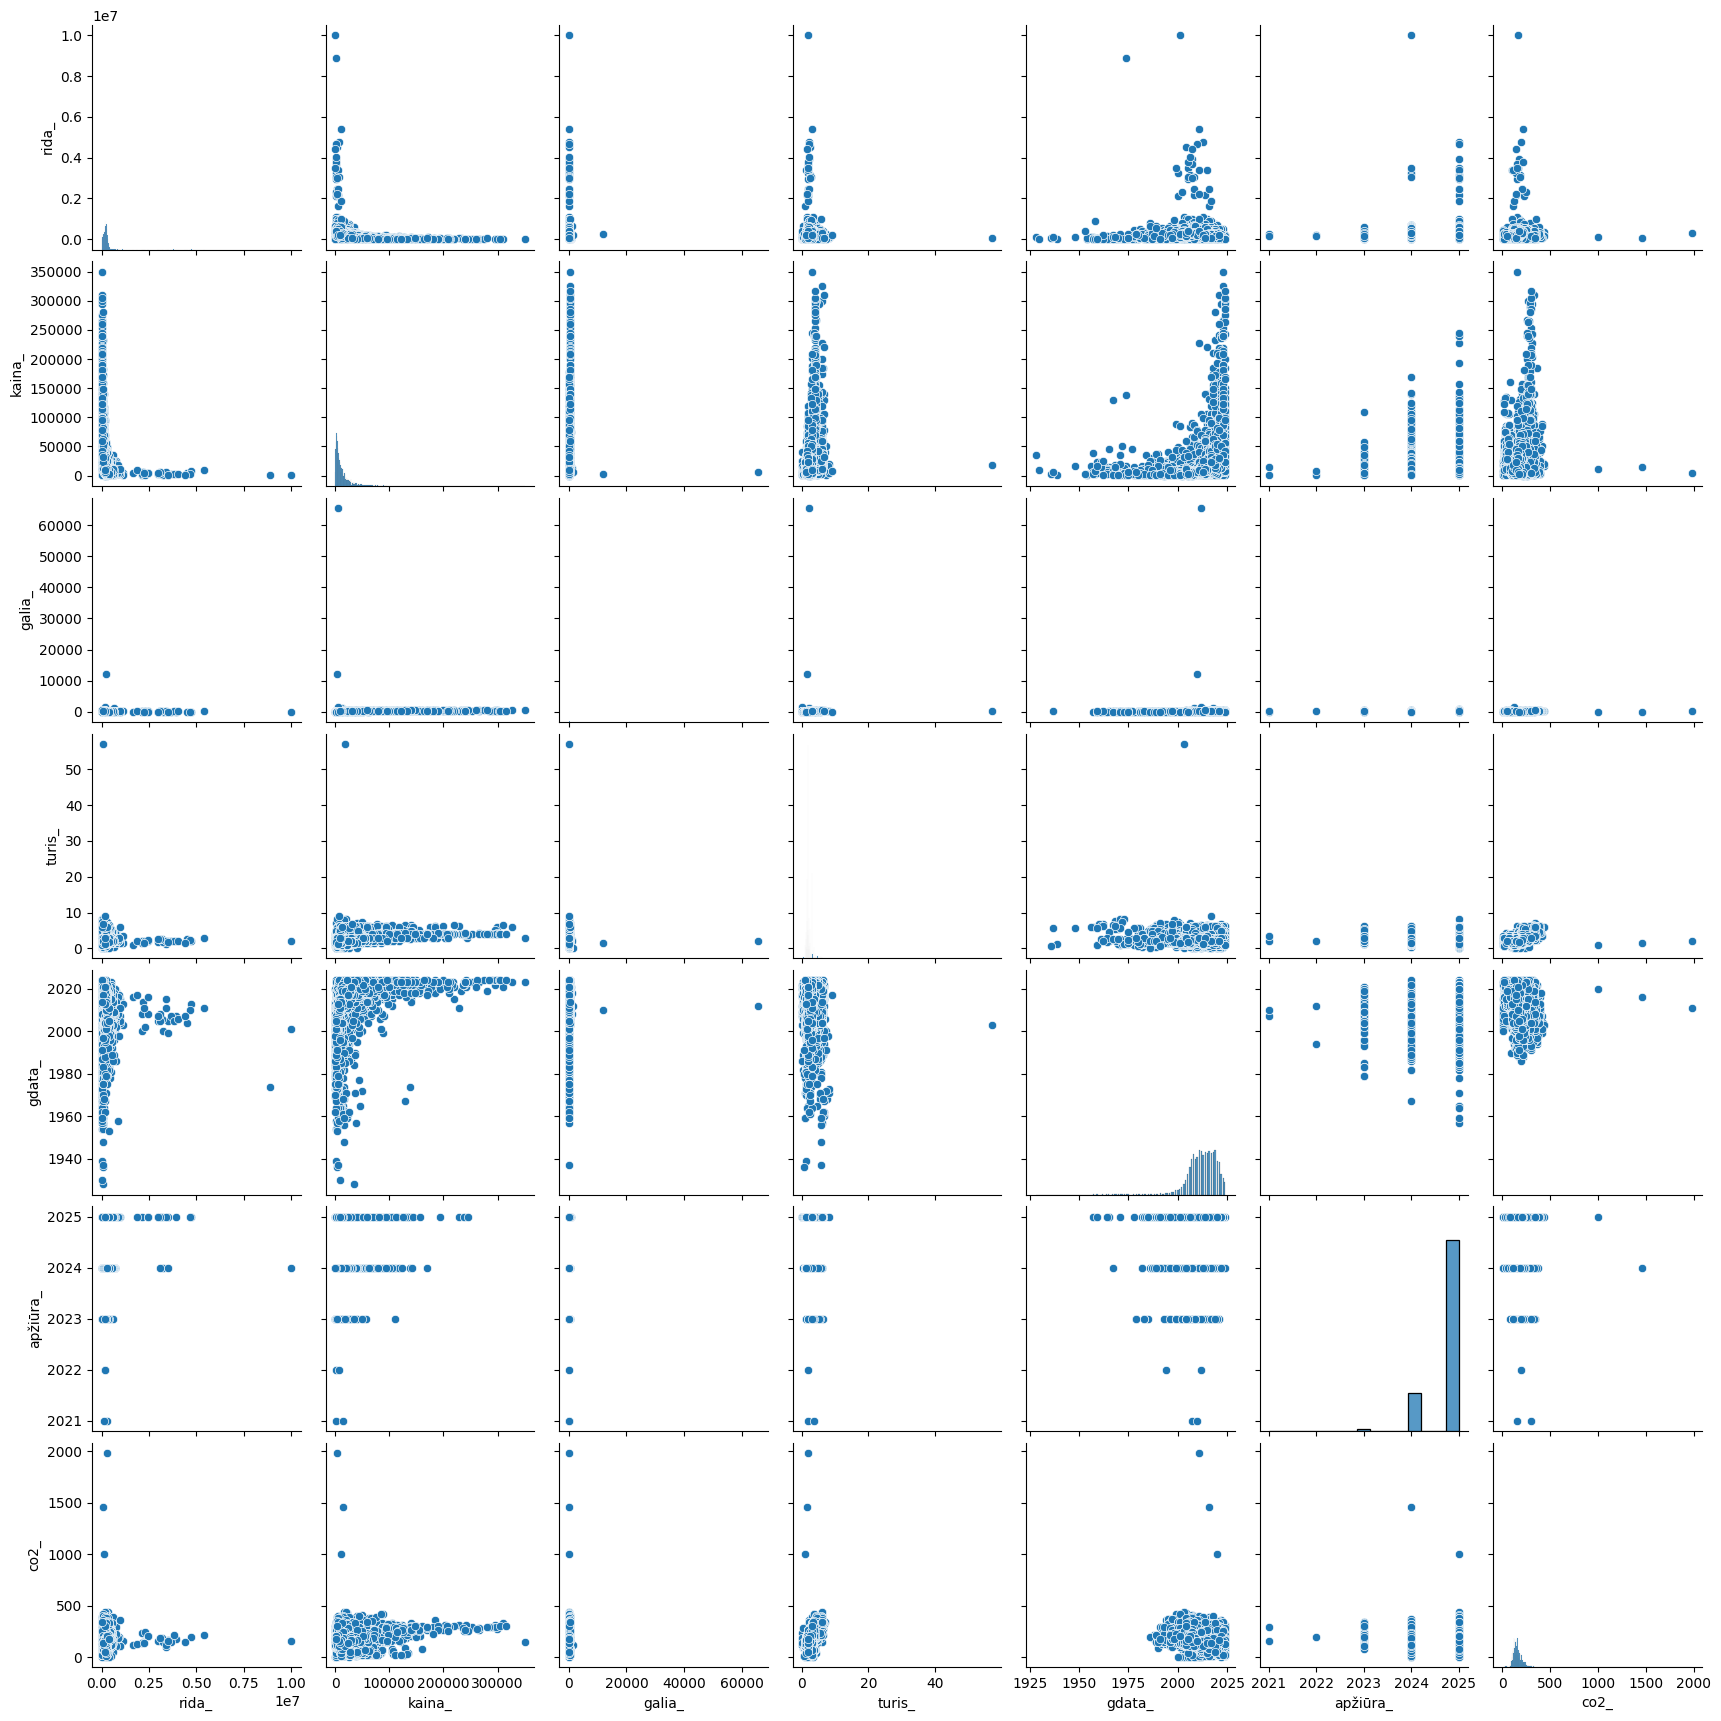

In [ ]:
print("Generuojamas sns.pairplot(data=df1), EliteBook 1+ minutė.")

sns.pairplot(data=df1)

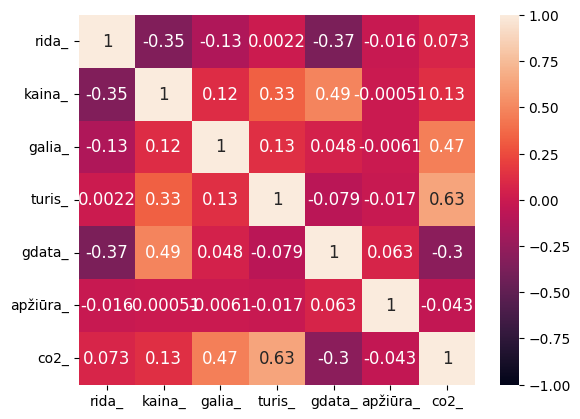

In [105]:
c = df1.corr(numeric_only=True,method='pearson')
ax = sns.heatmap(data=c,annot=True,annot_kws={'fontsize':12},vmin=-1,vmax=1)

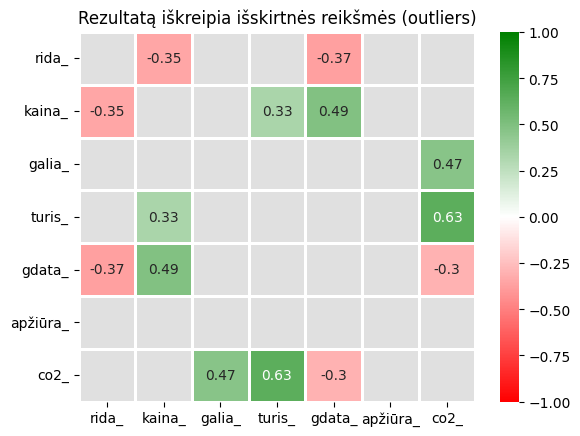

In [106]:
from matplotlib.colors import LinearSegmentedColormap

# Sukuriame pasirinktą spalvų schemą
colors = ["red", "white", "green"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap.set_bad(color="#E0E0E0")  # Pilka spalva `NaN` reikšmėms

cr_matrix = df1.corr(numeric_only=True,method='pearson')

# Nustatome modulio ribą
threshold = 0.2

# Panaikiname koreliacijas, kurių modulis mažesnis už ribą
cr_matrix = cr_matrix.where(abs(cr_matrix) >= threshold)

# Panaikiname įstrižainės reikšmes
np.fill_diagonal(cr_matrix.values, np.nan)

# Nubrėžiame heatmap su savo spalvų schema
sns.heatmap(data=cr_matrix,cmap=custom_cmap,annot=True,cbar=True,linecolor='white',linewidths='2',vmin=-1,vmax=1)

plt.title("Rezultatą iškreipia išskirtnės reikšmės (outliers)")
plt.show()